(psk)=
# Phase-shift keying

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sdr

%config InlineBackend.print_figure_kwargs = {"facecolor" : "w"}
%matplotlib inline
# %matplotlib widget

sdr.plot.use_style()

In the {obj}`sdr` library, phase-shift keying modulation is available in the {obj}`sdr.PSK` class.

In [2]:
def analyze_psk(psk, esn0):
    # Generate random decimal symbols
    s = np.random.randint(0, psk.order, 100_000)

    # Modulate decimal symbols to complex symbols
    x = psk.map_symbols(s)

    # Add AWGN to complex symbols to achieve desired Es/N0
    snr = sdr.esn0_to_snr(esn0, sps=1)
    x_hat = sdr.awgn(x, snr)

    plt.figure()
    plt.subplot(1, 2, 1)
    sdr.plot.symbol_map(psk.symbol_map, limits=(-2, 2))
    plt.subplot(1, 2, 2)
    sdr.plot.constellation(x_hat, bins=75, heatmap=True, limits=(-2, 2))
    plt.title(f"Constellation at {esn0} dB $E_s/N_0$")
    plt.suptitle(f"{psk.order}-PSK constellation")
    plt.show()

    y = psk.modulate(s)
    # h_srrc = sdr.root_raised_cosine(0.1, 6, sps)
    # tx_mf = sdr.Interpolator(sps, h_srrc)
    # y = tx_mf(x)

    plt.figure()
    sdr.plot.time_domain(y[0:1000])
    plt.show()

## Constellations

### BPSK

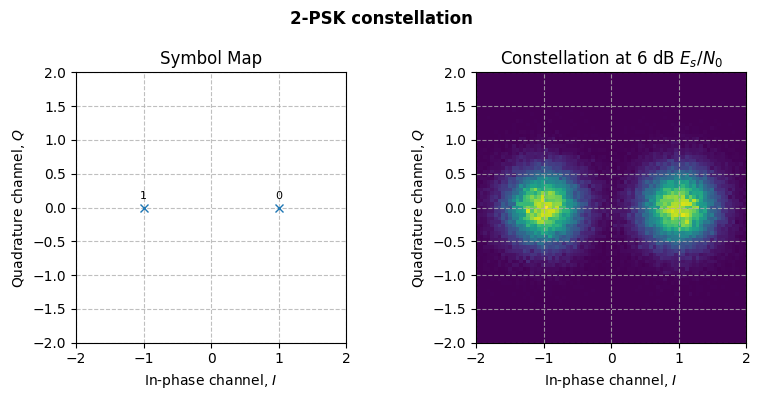

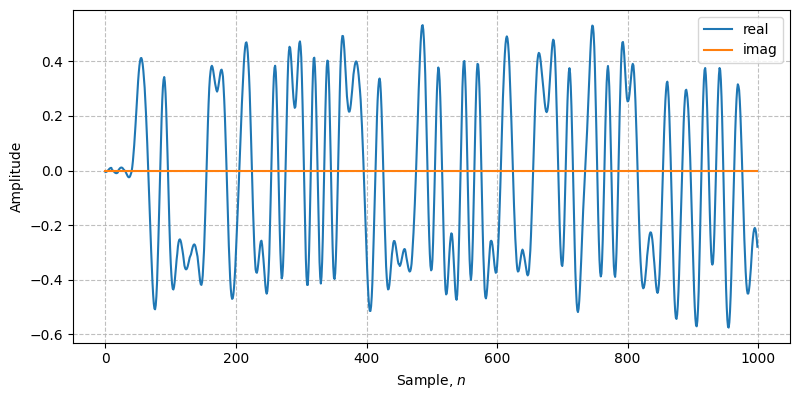

In [3]:
bpsk = sdr.PSK(2, sps=10, pulse_shape="srrc")
analyze_psk(bpsk, 6)

### QPSK

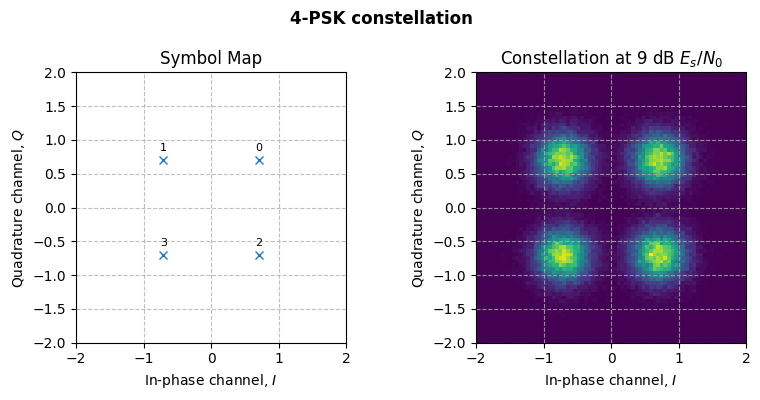

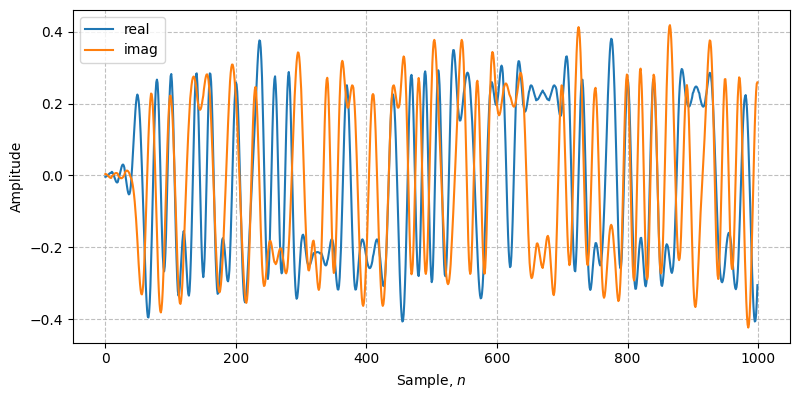

In [4]:
qpsk = sdr.PSK(4, phase_offset=45, sps=10, pulse_shape="srrc")
analyze_psk(qpsk, 9)

### 8-PSK

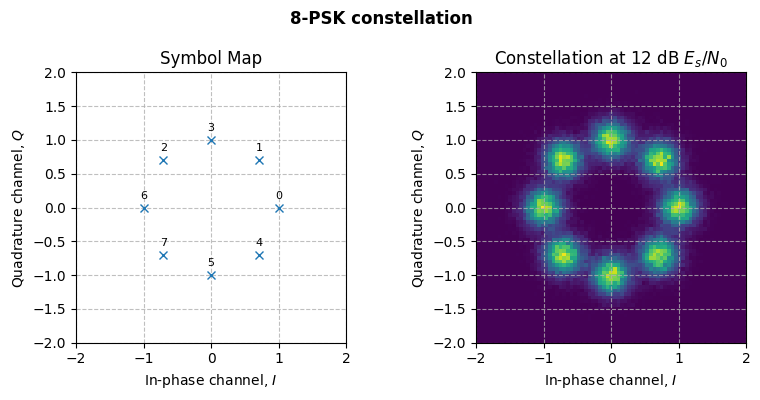

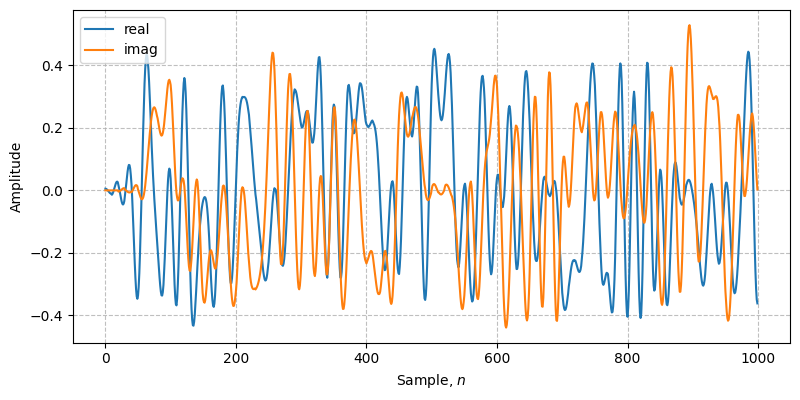

In [5]:
psk8 = sdr.PSK(8, sps=10, pulse_shape="srrc")
analyze_psk(psk8, 12)

### 16-PSK

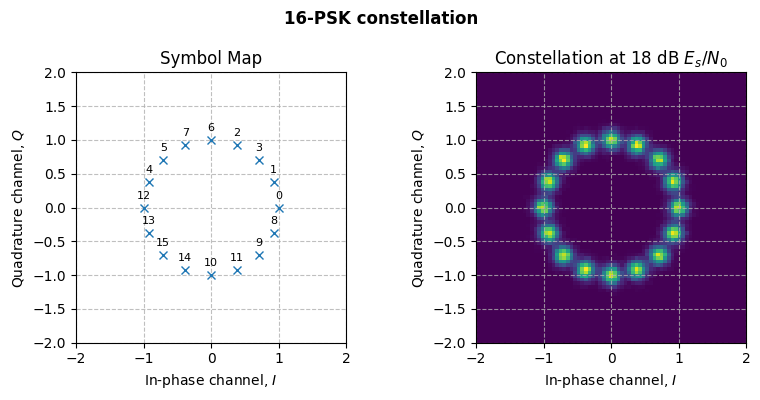

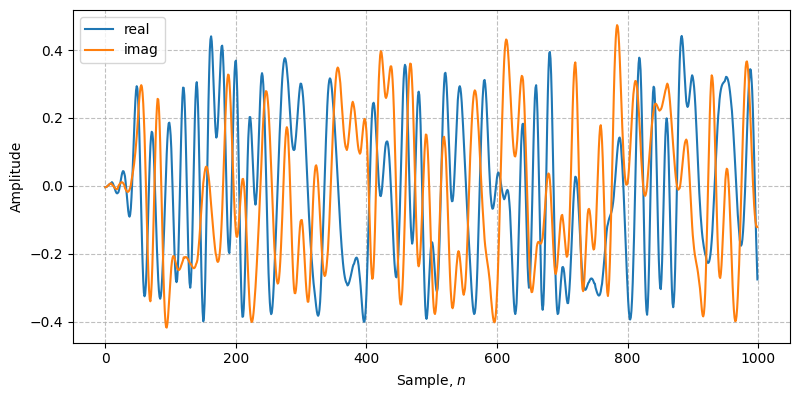

In [6]:
psk16 = sdr.PSK(16, sps=10, pulse_shape="srrc")
analyze_psk(psk16, 18)

## Error rate curves

In [7]:
def error_rates(psk, ebn0):
    esn0 = sdr.ebn0_to_esn0(ebn0, psk.bps)
    snr = sdr.esn0_to_snr(esn0)

    ber = sdr.ErrorRate()
    ser = sdr.ErrorRate()

    for i in range(snr.size):
        s = np.random.randint(0, psk.order, int(1e6))
        a = psk.map_symbols(s)
        a_tilde = sdr.awgn(a, snr[i])
        s_hat, a_hat = psk.decide_symbols(a_tilde)

        ber.add(ebn0[i], sdr.unpack(s, psk.bps), sdr.unpack(s_hat, psk.bps))
        ser.add(esn0[i], s, s_hat)

    return ber, ser

In [8]:
ebn0 = np.linspace(-2, 10, 20)

bpsk_ber, bpsk_ser = error_rates(bpsk, ebn0)
qpsk_ber, qpsk_ser = error_rates(qpsk, ebn0)
psk8_ber, psk8_ser = error_rates(psk8, ebn0)
psk16_ber, psk16_ser = error_rates(psk16, ebn0)

### Bit error rate curves

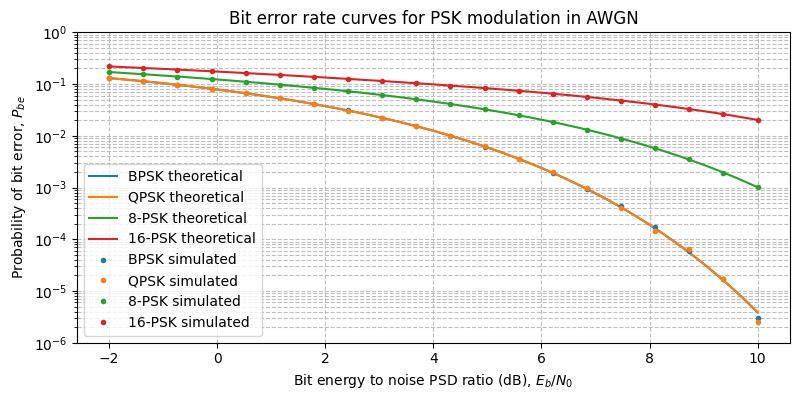

In [9]:
plt.figure()
ebn0 = np.linspace(-2, 10, 200)
sdr.plot.ber(ebn0, bpsk.ber(ebn0), label="BPSK theoretical")
sdr.plot.ber(ebn0, qpsk.ber(ebn0), label="QPSK theoretical")
sdr.plot.ber(ebn0, psk8.ber(ebn0), label="8-PSK theoretical")
sdr.plot.ber(ebn0, psk16.ber(ebn0), label="16-PSK theoretical")
plt.gca().set_prop_cycle(None)
sdr.plot.ber(*bpsk_ber.error_rates(), linestyle="none", marker=".", label="BPSK simulated")
sdr.plot.ber(*qpsk_ber.error_rates(), linestyle="none", marker=".", label="QPSK simulated")
sdr.plot.ber(*psk8_ber.error_rates(), linestyle="none", marker=".", label="8-PSK simulated")
sdr.plot.ber(*psk16_ber.error_rates(), linestyle="none", marker=".", label="16-PSK simulated")
plt.ylim(1e-6, 1e0)
plt.title("Bit error rate curves for PSK modulation in AWGN")
plt.show()

### Symbol error rate curves

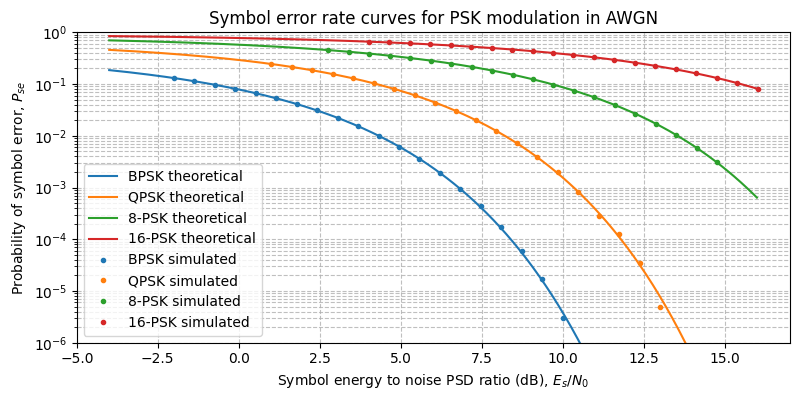

In [10]:
plt.figure()
esn0 = np.linspace(-4, 16, 200)
sdr.plot.ser(esn0, bpsk.ser(esn0), label="BPSK theoretical")
sdr.plot.ser(esn0, qpsk.ser(esn0), label="QPSK theoretical")
sdr.plot.ser(esn0, psk8.ser(esn0), label="8-PSK theoretical")
sdr.plot.ser(esn0, psk16.ser(esn0), label="16-PSK theoretical")
plt.gca().set_prop_cycle(None)
sdr.plot.ser(*bpsk_ser.error_rates(), linestyle="none", marker=".", label="BPSK simulated")
sdr.plot.ser(*qpsk_ser.error_rates(), linestyle="none", marker=".", label="QPSK simulated")
sdr.plot.ser(*psk8_ser.error_rates(), linestyle="none", marker=".", label="8-PSK simulated")
sdr.plot.ser(*psk16_ser.error_rates(), linestyle="none", marker=".", label="16-PSK simulated")
plt.ylim(1e-6, 1e0)
plt.title("Symbol error rate curves for PSK modulation in AWGN")
plt.show()

## Symbol mapping

The mapping of decimal symbols to complex symbols is important.
Ideally, adjacent symbol errors only result in 1 bit error.
This is generally accomplished using a Gray code (the default in :class:`sdr.PSK`).

In [11]:
psk8_bin = sdr.PSK(8, symbol_labels="bin")
psk8_gray = sdr.PSK(8, symbol_labels="gray")

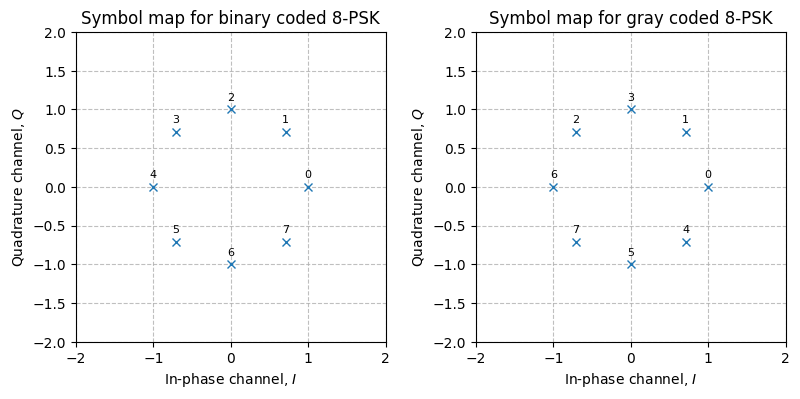

In [12]:
plt.figure()
plt.subplot(1, 2, 1)
sdr.plot.symbol_map(psk8_bin.symbol_map, limits=(-2, 2))
plt.title(f"Symbol map for binary coded 8-PSK")
plt.subplot(1, 2, 2)
sdr.plot.symbol_map(psk8_gray.symbol_map, limits=(-2, 2))
plt.title(f"Symbol map for gray coded 8-PSK")
plt.show()

Since adjacent symbol errors can lead to multiple bit errors, binary-coded 8-PSK has worse bit error performance.

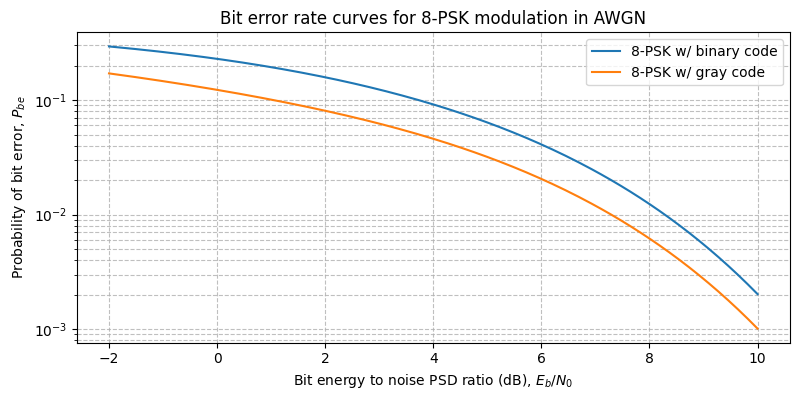

In [13]:
plt.figure()
ebn0 = np.linspace(-2, 10, 200)
sdr.plot.ber(ebn0, sdr.PSK(8, symbol_labels="bin").ber(ebn0), label="8-PSK w/ binary code")
sdr.plot.ber(ebn0, sdr.PSK(8, symbol_labels="gray").ber(ebn0), label="8-PSK w/ gray code")
plt.title("Bit error rate curves for 8-PSK modulation in AWGN")
plt.show()